In [1]:
from google.cloud import bigquery
from dotenv import load_dotenv

load_dotenv()

client = bigquery.Client()

QUERY = """SELECT DATE(usage_end_time) as end_date, 
        (SUM(CAST(cost AS NUMERIC))
            + SUM(IFNULL((SELECT SUM(CAST(c.amount AS NUMERIC))
                FROM UNNEST(credits) AS c), 0)))
            AS total_exact
        FROM `all_billing_data.gcp_billing_export_resource_v1_011093_DD21A6_63939E`
        GROUP BY end_date"""
query_job = client.query(QUERY)
rows = query_job.result()

row_list = list(rows)


In [26]:
import pandas as pd

df = pd.DataFrame(row_list)

df

,0
0,"(2023-09-08, 0.000769)"
1,"(2023-07-17, 0.000744)"
2,"(2023-07-01, -0.001038)"
3,"(2023-09-17, 0.000769)"
4,"(2023-07-16, 0.000744)"
5,"(2023-09-20, 0.000769)"
6,"(2023-07-14, 0.000744)"
7,"(2023-09-15, 0.000769)"
8,"(2023-09-07, 0)"
9,"(2023-09-22, 0.001249)"


In [27]:
df = df.rename(columns={0:'data'})

df['end_date'] = df['data'].apply(lambda x : x[0])
df['cost'] = df['data'].apply(lambda x : float(x[1]))

In [17]:
df = df.set_index('end_date')
df = df.sort_index()


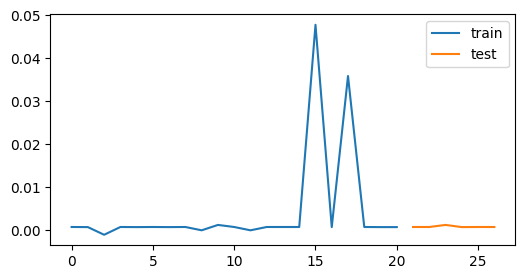

In [28]:
import matplotlib.pyplot as plt

steps = 6
train = df[:-steps]
test = df[-steps:]

fig, ax = plt.subplots(figsize=(6,3))
train['cost'].plot(ax=ax, label='train')
test['cost'].plot(ax=ax, label='test')
ax.legend()


In [33]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=train['cost'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 20] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-09-24 17:38:32 
Last fit date: 2023-09-24 17:38:33 
Skforecast version: 0.10.0 
Python version: 3.9.6 
Forecaster id: None 

21    0.029415
22    0.000778
23    0.031825
24    0.001220
25    0.009449
26    0.000949
Name: pred, dtype: float64
21    0.000769
22    0.000769
23    0.001249
24    0.000744
25    0.000769
26    0.000769
Name: cost, dtype: float64
-9316.499903657397


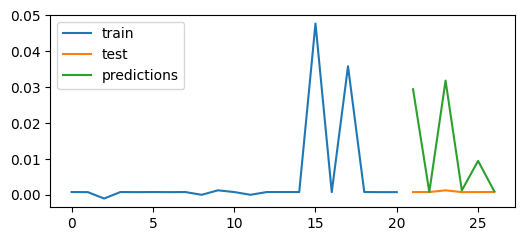

In [37]:
from sklearn.metrics import r2_score

predictions = forecaster.predict(steps=6)
print(predictions)
print(test['cost'])

fig, ax = plt.subplots(figsize=(6, 2.5))
train['cost'].plot(ax=ax, label='train')
test['cost'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
print(r2_score(test['cost'],predictions))

In [46]:
from skforecast.model_selection import grid_search_forecaster

lags_grid = [5, 6, 7, 8, 9]

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12
             )

param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['cost'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
               )

results_grid

Number of models compared: 30.


lags grid: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8 9] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.00030543690890909097



,lags,params,mean_squared_error,max_depth,n_estimators
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'max_depth': 5, 'n_estimators': 100}",0.000305,5,100
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'max_depth': 3, 'n_estimators': 100}",0.000305,3,100
28,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'max_depth': 10, 'n_estimators': 100}",0.000305,10,100
29,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'max_depth': 10, 'n_estimators': 500}",0.000305,10,500
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'max_depth': 5, 'n_estimators': 500}",0.000305,5,500
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'max_depth': 3, 'n_estimators': 500}",0.000305,3,500
1,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 500}",0.000311,3,500
3,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 500}",0.000311,5,500
5,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 500}",0.000311,10,500
0,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 100}",0.000311,3,100


-7144.573394879286


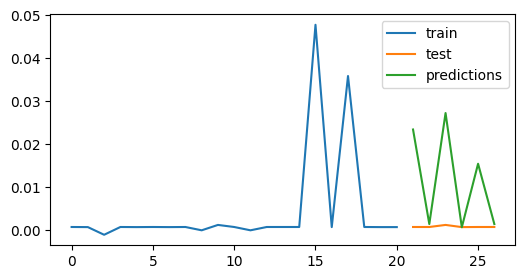

In [49]:
regressor = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 9
             )

forecaster.fit(y=train['cost'])

predictions = forecaster.predict(steps=steps)

fig, ax = plt.subplots(figsize=(6, 3))
train['cost'].plot(ax=ax, label='train')
test['cost'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
print(r2_score(test['cost'], predictions))